In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F


from collections import OrderedDict
from typing import List
from scipy.io import loadmat
from time import ctime

import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
matlab_data = loadmat("Project_IV_Data.mat")

u_bc = matlab_data['u_bc'] # 100 * 65
u_data = matlab_data['u_data'] # 100 * 65 * 65
v_data = matlab_data['v_data'] # 100 * 65 * 65
x_2d = matlab_data['x_2d'] # 65 * 65 个点的x坐标
y_2d = matlab_data['y_2d'] # 65 * 65 个点的y坐标


# 将numpy数组转换为torch张量
u_bc_tensor = torch.tensor(u_bc, dtype=torch.float32)
u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
v_data_tensor = torch.tensor(v_data, dtype=torch.float32)
x_2d_tensor = torch.tensor(x_2d, dtype=torch.float32)
y_2d_tensor = torch.tensor(y_2d, dtype=torch.float32)

# 使用 unsqueeze 在第 0 维度添加一个维度，将其变为 (1, 65, 65)
x_2d_tensor = x_2d_tensor.unsqueeze(0).repeat(100, 1, 1)
y_2d_tensor = y_2d_tensor.unsqueeze(0).repeat(100, 1, 1)

# 使用 unsqueeze 在第 2 维度添加一个维度，将其变为 (100, 65, 1)
expanded_tensor = u_bc_tensor.unsqueeze(2)

# 使用 zeros_like 创建一个形状为 (100, 65, 65) 的零张量
u_bc_tensor = torch.zeros((100, 65, 65), dtype=u_bc_tensor.dtype)

# 将 expanded_tensor 的值复制到 result_tensor 的第一列
u_bc_tensor[:, 0, :] = expanded_tensor.squeeze(2)


# # 分割训练和测试数据
# train_bc = u_bc_tensor[:90]
# test_bc = u_bc_tensor[90:]
# train_u_data = u_data_tensor[:90]
# test_u_data = u_data_tensor[90:]
# train_v_data = v_data_tensor[:90]
# test_v_data = v_data_tensor[90:]


In [3]:
u_bc_tensor.shape
x_2d_tensor.shape 
y_2d_tensor.shape

torch.Size([100, 65, 65])

In [4]:
# 构造输入数据：表示边界条件u0，x坐标和y坐标，化作100 * 65 * 65 * 3 的三维数据
x_train = torch.cat([u_bc_tensor.unsqueeze(-1), x_2d_tensor.unsqueeze(-1), y_2d_tensor.unsqueeze(-1)], dim=3)

In [5]:
x_train.shape

torch.Size([100, 65, 65, 3])

In [6]:
# 这里定义我们需要优化的函数，这个函数源自于深度神经网络（作为最基础的函数构型）
class DNN(torch.nn.Module):
     # 构造函数，输入是各层的神经元数量
    def __init__(self, layers: List[int]):
        super().__init__()
        
        # 网络深度和激活函数，定义网络深度和激活函数
        self.depth = len(layers) + 1
        self.activation = torch.nn.Tanh

        # 有序字典储存网络的各层结构
        layer_list = list()
        for i in range(len(layers)-1): 
            layer_list.append(
                # 链接各层网络
                (f'layer_{i}', torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
        # 构建字典，字典中包含了layer层与层之间的连接信息
        layerDict = OrderedDict(layer_list)

        # 序列式构造神经网络，通过字典构建序列式神经网络
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x: torch.tensor):
        # 神经网络基于输入张量x而得到输出
        out = self.layers(x)
        return out

In [7]:
# This is for FFT
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        # width = 20, modes1=12, modes2=12
        # in_channels = out_channels = width =20
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2 #傅里叶模态相乘的数量，最多floor(N/2) + 1

        self.scale = (1 / (in_channels * out_channels)) # 保证scale不变所设置的量
        # 先随机初始化两个parameter，维度为[20,20,12,12]，并乘上缩放因子scale
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # 定义向量乘的规则，即定义input和weights如何做乘，理解起来略微抽象
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        # 可以简单理解成前两个维度做向量乘，即(batch, in_channel),(in_channel, out_channel) -> (batch, out_channel）
        # [20,20,12,12] * [20,20,12,12] = [20,20,12,12]
        # 在这里主要是in_channel和out_channel与batch维度都是20，所以理解起来容易混淆
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        # 最初输入的x的维度为[20,64,64,20]->[bathsize，resolution，resolution，channel by fc0]
        # 经过permute之后，x的维度变成了[20, 20, 64, 64]，即[bathsize，channel by fc0，resolution，resolution]
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        # 将x做傅里叶变换，维度变为x_ft[20, 20, 64, 33]
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        # 定义out_ft变量用于存储结果，维度为[20, 12, 64, 33]，因为modes设置的是12，因此只有12个channel用于相乘
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        # 根据前面的向量乘法定义规则，即(batch, in_channel),(in_channel, out_channel) -> (batch, out_channel）
        # out_ft[0:20,0:12,0:12,0:12] = x_ft[0:20, 0:20, 0:12, 0:12] * weights1[0:20, 0:20, 0:12, 0:12]
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        # 同理，只不过倒着处理12个模态
        # out_ft[0:20,0:12,-12:end,-12:end] = x_ft[0:20,0:12,-12:end,-12:end] * weights2[0:20, 0:20, 0:12, 0:12]
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        # 经过一波相乘后，out_ft在[0,12]和[-12:end]处有信息，而之外的区间内是0
        # Return to physical space
        # 傅里叶逆变换，将傅里叶空间转换到物理空间
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [8]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        # input: the boundry conditions and coordinates of mesh 
        # input shape: (batchsize, x=65, y=65, c=3)
        # output: the solution of the next timestep
        # output shape: (batchsize, x=65, y=65, c=1)
        self.modes1 = modes1 # Fourier Layer所需要的参数
        self.modes2 = modes2 # Fourier Layer所需要的参数
        self.width = width # Fourier Layer所需要的参数
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) #将输入的12个channel映射到想要的channel，这里设置为width个channel
        # 4个Fourier Layer
        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        # 类似ResNet的shortcut结构
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        # 设置了bn层，但是该代码并没有使用
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        # 全连接层，用于将channel数从width映射到128
        self.fc1 = nn.Linear(self.width, 128)
        # 全连接层，用于将channel数从128映射到1，即得到最终输出的维度
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # 这部分就是源代码注释里的 10 timesteps + 2 locations，增加两个维度存储位置信息
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        # 经过Fourier Layer 0
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        # 经过Fourier Layer 1
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        # 经过Fourier Layer 2
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        # 经过Fourier Layer 3
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # 经过两个全连接层，将channel维度映射到目标输出的维度
        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [9]:
# Fourier层中的两个参数，后文讲解
modes = 12
width = 20
# bath_size
batch_size = 20
batch_size2 = batch_size
# 基本的训练参数
epochs = 500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

In [10]:
model = FNO2d(modes, modes, width)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, u_data_tensor, v_data_tensor), batch_size=batch_size, shuffle=True)

for ep in range(epochs):
    model.train()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy, zz in train_loader:
        loss = 0
        # xx是input，yy是label，即对应前面的train_a和train_u
        xx = xx.to(device)
        yy = yy.to(device)
        zz = zz.to(device)
        # 这里需要注意的是，对t在[10,20）的输出方式是滚动的
        # 即输入T[0,10)，输出T[10]，得到T[10]后，下一轮输入T[0,11)，输出T[11]
        # 每次只输出一个时间点的结果，输入该时间点之前的所有结果
        # 具体时间点label的值，该场景下step被设置为1
        y = yy
        z = zz
        # 输入xx得到FNO的输出im
        im = model(xx)
        u_pred = im[:, :, :, 0]
        v_pred = im[:, :, :, 1]
        # loss是累加的，在输出完[10,20）所有结果后再更新参数
        loss += torch.mean((yy - u_pred) ** 2) + torch.mean((zz - v_pred) ** 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (ep+1) % 10 == 0:
            print(f'Epoch {ep+1}, Loss: {loss / len(train_loader)}')

Epoch 10, Loss: 0.0030924896709620953
Epoch 10, Loss: 0.0030380655080080032
Epoch 10, Loss: 0.0026898286305367947
Epoch 10, Loss: 0.0026459363289177418
Epoch 10, Loss: 0.0023470409214496613
Epoch 20, Loss: 0.0008876832434907556
Epoch 20, Loss: 0.000975899223703891
Epoch 20, Loss: 0.0008029371383599937
Epoch 20, Loss: 0.0009294800693169236
Epoch 20, Loss: 0.0010314721148461103
Epoch 30, Loss: 0.0006349948234856129
Epoch 30, Loss: 0.0007225869921967387
Epoch 30, Loss: 0.000651989714242518
Epoch 30, Loss: 0.0006776954978704453
Epoch 30, Loss: 0.0006831823848187923
Epoch 40, Loss: 0.0007860401528887451
Epoch 40, Loss: 0.0004560920351650566
Epoch 40, Loss: 0.0005029599997214973
Epoch 40, Loss: 0.0006398875848390162
Epoch 40, Loss: 0.0007330557564273477
Epoch 50, Loss: 0.000769614358432591
Epoch 50, Loss: 0.0006103978375904262
Epoch 50, Loss: 0.0006602578796446323
Epoch 50, Loss: 0.000408622290706262
Epoch 50, Loss: 0.0006461363518610597
Epoch 60, Loss: 0.00046282936818897724
Epoch 60, Loss:

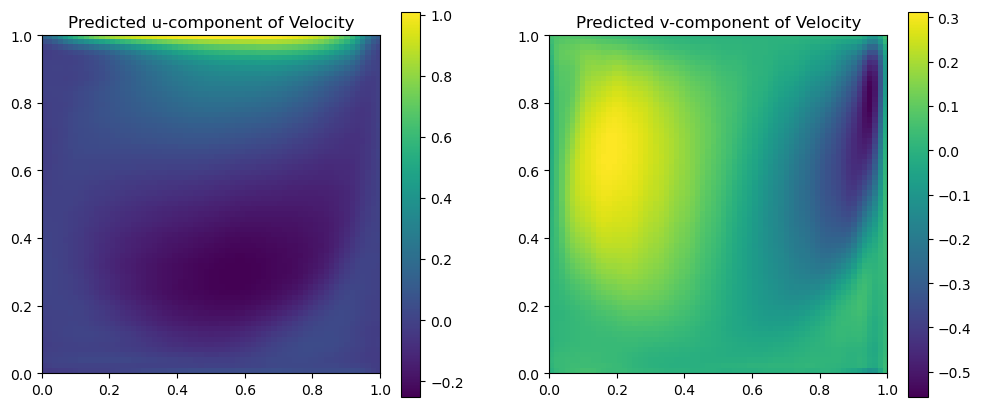

In [17]:
# 可视化函数
import matplotlib.pyplot as plt
def visualize_results(model, x_train):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 关闭梯度计算
        # 预测速度场
        # 由于模型现在需要边界条件作为输入，我们将使用一组扩展的边界条件进行预测
        # 使用第一个案例的边界条件进行演示
        u_pred = model(x_train[8:9]).reshape(65, 65, 2)
        u_pred = u_pred.detach().numpy()

    # 绘制速度场的u分量
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(u_pred[:, :, 0], origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title('Predicted u-component of Velocity')

    # 绘制速度场的v分量
    plt.subplot(1, 2, 2)
    plt.imshow(u_pred[:, :, 1], origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title('Predicted v-component of Velocity')

    plt.show()

# 可视化训练后的模型结果
visualize_results(model, x_train)